# Classification
In this workbook we'll be using the MNIST datasets that contains 70,000 small images of digits handwritten.

## The MNIST dataset

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


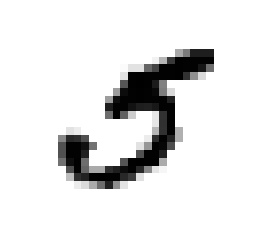

label: 5.0


In [9]:
# Let's take a look at one of the records
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28) # rehape row into the 28 by 28 pixel representation

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()
print("label: " + str(y[36000]))

In [11]:
# Let's split the dataset into the predefined train and test sets.
# Train = first 60,00 images, Test = last 10,000 images

X_train, X_test, y_train, y_test = X[:60000], X[6000:], y[:60000], y[60000:]

In [14]:
# Next let's shuffle the training dataset to ensure it's not stored in an order fassion.

import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier
Let's start with a simplier proble, trying to detect the digit 5.

In [15]:
# First we create the target vectors 
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [21]:
# Next we'll start with a simple ML algorithm. Stochastic Gradient Descent (SGB)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [22]:
# Now we can use it to make predictions on our ealier random observation (some_digit, which is equal to 5)
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

## Performance Measures for Classification Problem

#### 1. Measuring Accuracy Using Cross-Validation
Sometimes we'll need more control over the cross-validation process.
This functions does roughly the same thing as Scikit-Learn's cross_val_score()

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    

0.96045
0.9694
0.9596


In [25]:
# Now let's use the cross_val_score from Scikit learn
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.96045,  0.9694 ,  0.9596 ])

## 2. Confusion Matrix
Accuracy by itself is a very poor measure for classification problems. An classifier that always predicted the majority 
class would achieve a high accuracy in imbalanced problems.

Instead a confusion matrix is used.

In [32]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

print(confusion_matrix(y_train_5, y_train_pred))
print("Each row represents the actual lables (0, 1), and the columns represents the predictions (0, 1)")

[[53940   639]
 [ 1572  3849]]
Each row represents the actual lables (0, 1), and the columns represents the predictions (0, 1)


### Precision & Recall
Precision - ( TP/ TP + FP), The accuracy of the positive predictions. How many of the predicted postive lables were actually positive. 

Recall (or Senstivity or True Positive Rate) - (TP / TP + FN), The positive prediction hit rate (the ratio of postive instances correctly classified). How many of the positive labels did you correctly detect.  

In [37]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.857620320856
0.710016602103


### The F1 Score
It is often useful to combine precision and recall into a single metric called the F1 score. 
It represents the harmonic mean of precision and recall. Whereas a regualr mean treats all value equally, 
This gives more weight to low values, and thus you can only get high F1 score if both precision and recall are high. 

In [39]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.77686951256433545

### Precision/Recall Tradeoff

The F1 score favours classifiers that have similar precision and recall, which is not always what you want. 

For example in Fraud Detectection you'll trade off Precision for higher Recall. But in classifiying children videos as safe/unsafe you'll want a high Precision and can afford to loose some Recall.

Unfortunately you can't have it both ways, increasing on metric will decrease the other.

In [40]:
# To access the raw propensity scores and then implement any threshold you can use decision_function()

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 44642.81087184])

In [43]:
threshold = 0   # The same as the SGDClassifier threshold.
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True], dtype=bool)

In [44]:
# Let's try another threshold and check how  it affects the result. 
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
# Increasing the threshold decreases the recall.

array([False], dtype=bool)

In [47]:
# Now let's decide which threshold to use.

# First - Generate the scores for all instances of the training set.
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

# Second - With those scores we compute t he precision and recall for all posible thresholds.
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

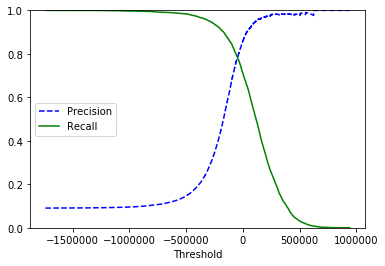

In [49]:
# Next we'll plot the precision and recall as functions of the threshold value.

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

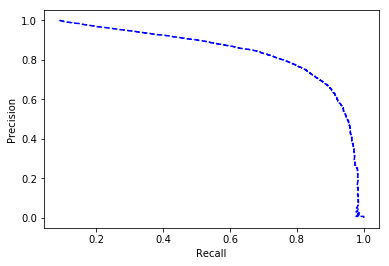

In [52]:
# Another method to determine the good precision/recall tradeoff is to plot the precision directly against recall.

plt.plot(precisions,recalls, "b--", label="Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [56]:
# once we select a precision recall tradeoff that we're happy with
# , we return the precision recall threshold plot to get the threshold. In this case a 90% precision gives 70,000 threshold.

# Now instead of callde predict(), we can just run
y_train_pred_90 = (y_scores > 70000)

print("Precision: ", precision_score(y_train_5, y_train_pred_90))
print("Recall: ", recall_score(y_train_5, y_train_pred_90))

Precisio:  0.922632794457
Recall:  0.589559121933


### ROC Curve
The Reciever Operator Characteristic (ROC) curve is another another common tool used for binary classifiers.
ROC curves plots the True Positive Rate (recall) against False Positive Rate (FPR). FPR is the ratio of negative instances that are incorrectlly classified as postive. It is equal to one minus the True Negative Rate (TNR), which is also called Specificity.
Therefore the ROC curve is the Sensitivity (Recall) vs. 1 - Specificity.

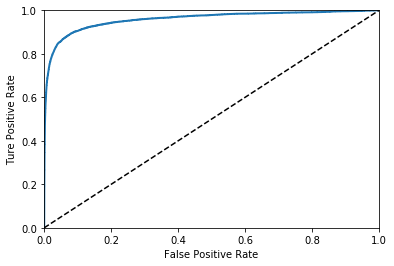

In [60]:
# First we need to compute the TPR and FPR for various thresholds.
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

# Then we can plot the FPR against the TPR
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0,1, 0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('Ture Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()
# Again there tradeoff, the higher the True Positive Rate, the higher the False Positive Rate. 

In [61]:
# The Area Under the Curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.95906276048887618

In [62]:
# Now let's train a RandomForest ans compare it to our SGD classifier.
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probs_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                  method="predict_proba")

In [64]:
# We only need the positive probability, so we'll only keep that.
y_positive_probs_forest = y_probs_forest[:,1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_positive_probs_forest)

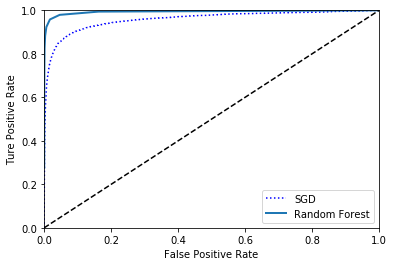

Stochastic Gradient Descent:  0.959062760489
Random Forest AUC:  0.99360586116


In [72]:
# Now we are ready to plot the ROC curve, and compare the two models.

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")
plt.legend(loc="lower right")
plt.show()

print("Stochastic Gradient Descent: ", roc_auc_score(y_train_5, y_scores))
print("Random Forest AUC: ", roc_auc_score(y_train_5, y_positive_probs_forest))

In [77]:
# Let's finally check the precision and recall of the RF and the precision recall curve
#from sklearn.metrics import precision_score, recall_score

rf_threshold = 0.5   # The same as the SGDClassifier threshold.
y_train_pred_rf = (y_positive_probs_forest > rf_threshold)

print("Random Forest Precision : ", precision_score(y_train_5, y_train_pred_rf))
print("Random Forest Recall : ", recall_score(y_train_5, y_train_pred_rf))

Random Forest Precision :  0.986766651963
Random Forest Recall :  0.825308983582


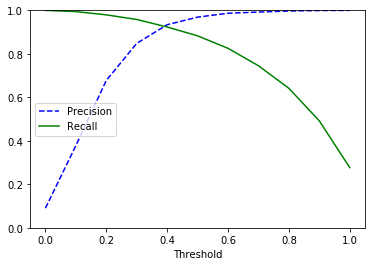

In [80]:
# Precision Recall Threshold selection
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_positive_probs_forest)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()